In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import numpy as np
%matplotlib inline

In [11]:
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split

emma = gutenberg.paras('austen-emma.txt')
print(emma[0:100])

[[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']']], [['VOLUME', 'I']], ...]


In [9]:
#Processing
emma_paras=[]
for paragraph in emma:
    para = paragraph[0]
    para = [re.sub(r'--', '', word) for word in para]
    emma_paras.append(' '.join(para))
                   
print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, #drop words that occur in more than half the paragraphs
                            min_df=2, #only use words that appear at least twice
                            stop_words='english', 
                            lowercase=True, #convert everything to lower case
                            use_idf=True, #use inverse document frequencies in our weighting
                            norm=u'l2', #applies a correction factor so short and long paragraphs are treated equally
                            smooth_idf=True #adds 1 to all document frequencies, prevents divide by 0 errors
                           )

#applying the vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of features: %d' % emma_paras_tfidf.get_shape()[1])

#Split into train and test.
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)
#Reshape the vectorizer
X_train_tfidf_csr = X_train_tfidf.tocsr() #Return a copy of this matrix in Compressed Sparse Row format

#Number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, list the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]
    
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

#tf-idf score of 0 indicates that the word was present once in that sentence (log2(1) is 0)
#Now we have one vector per paragraph.

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.71274503103825837, 'present': 0.70142321085794701}


In [18]:
from sklearn.decomposition import TruncatedSVD #Singular Value Decomposition
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Reduce the feature space to 130
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False)) #LSA is latent semantic analysis

#Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

#Analyze what sorts of paragraphs our solution considers similar, for the first five identified topics.
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.1951167044
Component 0
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
Name: 0, dtype: float64
Component 1
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633678
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.583287
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.565639
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                       

Component 0 - Oh!
Component 1 - Critical dialogue directed at Emma
Component 2 - Chapters
Component 3 - Ah! exclamations
Component 4 - Actions/directions related to Emma

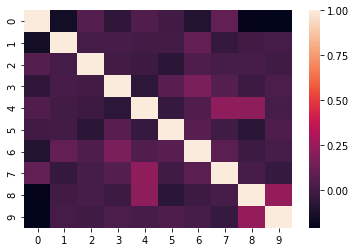

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [21]:
#Look at similarities of the first 10 sentences in the training set. 
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only take the first 10 sentences
sim_matrix = pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]

#Make a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

#Generate a key.
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [22]:
#Trying the model on the test set.
#Reshape the vectorizer
X_test_tfidf_csr = X_test_tfidf.tocsr() #Return a copy of this matrix in Compressed Sparse Row format

#Number of paragraphs
n = X_test_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, list the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i,j]
    
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara[5])

#tf-idf score of 0 indicates that the word was present once in that sentence (log2(1) is 0)
#Now we have one vector per paragraph.

Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'resolving': 0.34243903050458052, 'unexceptionable': 0.31964097921179369, 'assure': 0.26772977783606899, 'friends': 0.25153337406413429, 'quite': 0.19164719184203469, 'replied': 0.20315405638674577, 'watch': 0.62300800500314002, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}


In [27]:
#Reduce the feature space to 130
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False)) #LSA is latent semantic analysis

#Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

#Analyze what sorts of paragraphs our solution considers similar, for the first five identified topics.
paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.3755247306
Component 0
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh no !    0.99992
Name: 0, dtype: float64
Component 1
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.618506
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                   

Component 0 - Oh!
Component 1 - Conversations between Mrs Weston, Emma, Mr Knightley
Component 2 - Ah! 
Component 3 - Emotions
Component 4 - Yes statements